In [1]:
import os
from PIL import Image
import numpy as np
from keras.layers import Input, Convolution2D, merge, Dense, Dropout, Flatten, Conv2D, MaxPooling3D
from keras.models import Model, Sequential
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h5py
import math
from skimage.io import imread
from matplotlib import pyplot as plt
import sklearn.feature_extraction
import sklearn.feature_selection as t
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
import scipy.ndimage.filters
import random

Using TensorFlow backend.


In [2]:
def PSNR(y_true, y_pred):
    return 10.0 * K.log(1 / (K.mean(K.square(y_pred - y_true)))) / K.log(10.0)

In [3]:
def threecompare(in_im, out_im, pred_im):
    img1 = out_im*255
    img2 = in_im*255
    kernel = np.ones((3,3))*(-1)
    kernel[1,1] = 8
    new_im = channels2data(img2)
    h_im = np.zeros((img2.shape[2], img2.shape[0], img2.shape[1]))
    for i in range(img2.shape[2]):
        h = new_im[i]
        h = h.reshape(img2.shape[0], img2.shape[1])
        lap = scipy.ndimage.filters.convolve(h, kernel)
        laps = lap*100.0/np.amax(lap)
        h_im[i] = (h + laps/10)
    img3 = data2channels(h_im).astype('float32')
    img4 = pred_im*255
    ssim1 = ssim(img1, img1, data_range=img1.max() - img1.min(), multichannel=True)
    ssim2 = ssim(img1, img2, data_range=img2.max() - img2.min(), multichannel=True)
    ssim3 = ssim(img1, img3, data_range=img3.max() - img3.min(), multichannel=True)
    ssim4 = ssim(img1, img4, data_range=img4.max() - img4.min(), multichannel=True)
    label = 'SSIM: {:.2f}'
    print('Original image')
    print(label.format(ssim1))
    print('\n'+'Bicubic image')
    print(label.format(ssim2))
    print('\n'+'Bicubic with laplasian image')
    print(label.format(ssim3))
    print('\n'+'Produced image')
    print(label.format(ssim4))

In [4]:
def imload(d, mode, channels, img_rows, img_cols):
    directory = '../Картинки/'+d
    files = os.listdir(directory)
    flag = True
    i = 0
    while flag and i < len(files):
        if files[i] == '.DS_Store':
            del files[i]
            flag = False
        i+= 1
    num = 0
    for name in range(len(files)):
        im = Image.open(directory+'/'+ files[name]).convert('L')
        width, height = im.size
        num += (width//img_rows)*(height//img_cols)
    num = num*4
    x = np.zeros((num, img_rows, img_cols, channels))
    y = np.zeros((num, img_rows, img_cols, channels))
    num1 = np.zeros((num))
    num = 0
    for name in range(len(files)):
        I = Image.open(directory+'/'+ files[name]).convert('RGB')
        width1, height1 = I.size
        if (width1//img_rows > 1) and (height1//img_cols > 1):
            for i in range(width1//img_rows):
                for j in range(height1//img_cols):
                    im = I.crop((i*img_rows, j*img_cols, (i+1)*img_rows, (j+1)*img_cols))
                    width, height = im.size
                    for k in range(4):
                        im_ = im.rotate(90*k)
                        a = np.asarray(im_).astype('float32')
                        im1 = im_.resize((int(width/2), int(height/2)))
                        im1 = im1.resize((width, height), Image.BICUBIC)
                        a1 = np.asarray(im1).astype('float32')
                        a = a.reshape(img_rows, img_cols, channels)
                        a1 = a1.reshape(img_rows, img_cols, channels)
                        flag = True
                        while flag:
                            e = random.randint(0, len(num1)-1)
                            if num1[e] != 1:
                                flag = False
                        num1[e] = 1
                        x[e] = a1
                        y[e] = a
        elif width1//img_rows > 1:
            for i in range(width1//img_rows):
                im = I.crop((i*img_rows, 0, (i+1)*img_rows, img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        elif height1//img_cols > 1:
            for j in range(height1//img_cols):
                im = I.crop((0, j*img_cols, img_rows, (j+1)*img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        else:
            im = I.crop((0,0,img_rows, img_cols))
            width, height = im.size
            for k in range(4):
                im_ = im.rotate(90*k)
                a = np.asarray(im_).astype('float32')
                im1 = im_.resize((int(width/2), int(height/2)))
                im1 = im1.resize((width, height), Image.BICUBIC)
                a1 = np.asarray(im1).astype('float32')
                a = a.reshape(img_rows, img_cols, channels)
                a1 = a1.reshape(img_rows, img_cols, channels)
                flag = True
                while flag:
                    e = random.randint(0, len(num1)-1)
                    if num1[e] != 1:
                        flag = False
                num1[e] = 1
                x[num] = a1
                y[num] = a
                num += 1
    return x, y

In [5]:
def preprocess(x, y, channels, img_rows, img_cols):
    x /= 255
    y /= 255
    x = x.astype('float32')
    y = y.astype('float32')
    x = x.reshape(x.shape[0], img_rows, img_cols, channels)
    y = y.reshape(y.shape[0], img_rows, img_cols, channels)
    return x, y

In [6]:
def getim(im):
    im1 = Image.new('RGB', (im.shape[0],im.shape[1]))
    p = im1.load()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            helper = []
            for k in range(im.shape[2]):
                if int(im[i][j][k]) > 255:
                    helper.append(255)
                elif int(im[i][j][k]) < 0:
                    helper.append(0)
                else:
                    helper.append(int(im[i][j][k]))
            p[i,j] = tuple(helper)
    return im1

In [7]:
def channels2data(im):
    answer = np.zeros((im.shape[2], im.shape[0], im.shape[1]))
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for k in range(im.shape[2]):
                answer[k,i,j] = im[i,j,k]
    return answer

In [8]:
def data2channels(ar):
    answer = np.zeros((ar.shape[1], ar.shape[2], ar.shape[0]))
    for i in range(ar.shape[0]):
        for j in range(ar.shape[1]):
            for k in range(ar.shape[2]):
                answer[j,k,i] = ar[i,j,k]
    return answer

In [9]:
def results(x, y, p, img_rows, img_cols, f):
    PSNR_bicubic = 0
    PSNR_laplasian = 0
    PSNR_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        im2 = y[i]*255
        im3 = p[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        new_im = channels2data(im1)
        h_im = np.zeros((im1.shape[2], im1.shape[0], im1.shape[1]))
        for l in range(im1.shape[2]):
            h = new_im[l]
            h = h.reshape(im1.shape[0], im1.shape[1])
            lap = scipy.ndimage.filters.convolve(h, kernel)
            laps = lap*100.0/np.amax(lap)
            h_im[l] = (h + laps/10)
        im4 = data2channels(h_im)
        answer1 = getim(im1)
        answer1.save('model 2-3 color/original/'+f+'/image '+str(i)+' bicubic.png','png')
        answer2 = getim(im2)
        answer2.save('model 2-3 color/original/'+f+'/image '+str(i)+' original.png','png')
        answer3 = getim(im3)
        answer3.save('model 2-3 color/original/'+f+'/image '+str(i)+' worked.png','png')
        answer4 = getim(im4)
        answer4.save('model 2-3 color/original/'+f+'/image '+str(i)+' with laplasian.png','png')
        PSNR_bicubic += 10.0 * np.log(255*255 / (np.mean(np.square(im1 - im2)))) / np.log(10.0)
        PSNR_laplasian += 10.0 * np.log(255*255 / (np.mean(np.square(im4 - im2)))) / np.log(10.0)
        PSNR_model += 10.0 * np.log(255*255 / (np.mean(np.square(im3 - im2)))) / np.log(10.0)    
    print('Bicubic PSNR:', PSNR_bicubic/len(x))
    print('Laplasian PSNR:', PSNR_laplasian/len(x))
    print('Model PSNR:', PSNR_model/len(x))

In [10]:
def ressim(x, y, p, img_rows, img_cols):
    SSIM_bicubic = 0
    SSIM_laplasian = 0
    SSIM_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        new_im = channels2data(im1)
        h_im = np.zeros((im1.shape[2], im1.shape[0], im1.shape[1]))
        for l in range(im1.shape[2]):
            h = new_im[l]
            h = h.reshape(im1.shape[0], im1.shape[1])
            lap = scipy.ndimage.filters.convolve(h, kernel)
            laps = lap*100.0/np.amax(lap)
            h_im[l] = (h + laps/10)
        im4 = data2channels(h_im).astype('float32')
        im2 = y[i]*255
        im3 = p[i]*255
        SSIM_bicubic += ssim(im1, im2, data_range=im1.max() - im2.min(), multichannel=True)
        SSIM_laplasian += ssim(im4, im2, data_range=im4.max() - im2.min(), multichannel=True)
        SSIM_model += ssim(im3, im2, data_range=im3.max() - im2.min(), multichannel=True)
    print('Bicubic SSIM:', SSIM_bicubic/len(x))
    print('Laplasian SSIM:', SSIM_laplasian/len(x))
    print('Model SSIM:', SSIM_model/len(x))

In [11]:
img_rows, img_cols = 100, 100
mode = 'RGB'
channels = 3

In [12]:
batch_size = 15
nb_epoch = 500
n1 = 10
f1 = 15
n2 = 3
f2 = 1

In [13]:
X_train, Y_train = imload('Train/Train_first', mode, channels, img_rows, img_cols)
X_test, Y_test = imload('Test/Test_first', mode, channels, img_rows, img_cols)
X_test5, Y_test5 = imload('Test/Set5', mode, channels, img_rows, img_cols)
X_test14, Y_test14 = imload('Test/Set14', mode, channels, img_rows, img_cols)
X_valid, Y_valid = imload('Validation/Validation_first', mode, channels, img_rows, img_cols)

In [14]:
in_train, out_train = preprocess(X_train, Y_train, channels, img_rows, img_cols)
in_test, out_test = preprocess(X_test, Y_test, channels, img_rows, img_cols)
in_test5, out_test5 = preprocess(X_test5, Y_test5, channels, img_rows, img_cols)
in_test14, out_test14 = preprocess(X_test14, Y_test14, channels, img_rows, img_cols)
in_valid, out_valid = preprocess(X_valid, Y_valid, channels, img_rows, img_cols)

In [15]:
input_shape = (img_rows, img_cols, channels)
model = Sequential()
model.add(Conv2D(n1, (f1, f1), input_shape=input_shape, activation='relu', name='filters', padding="same")) #активацию убать
model.add(Conv2D(n2, (f2, f2), padding="same", name='output'))
model.compile(loss="mse", optimizer="adam", metrics=[PSNR])

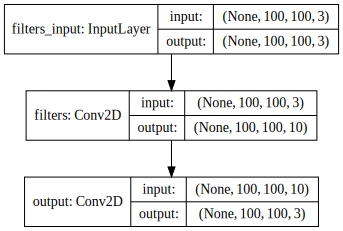

In [16]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
history = model.fit(in_train, out_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(in_valid, out_valid))

Train on 1224 samples, validate on 176 samples
Epoch 1/500
1224/1224 [==============================] - 152s 124ms/step - loss: 0.0328 - PSNR: 16.0130 - val_loss: 0.0174 - val_PSNR: 18.1328
Epoch 2/500
1224/1224 [==============================] - 134s 109ms/step - loss: 0.0135 - PSNR: 18.8899 - val_loss: 0.0139 - val_PSNR: 19.1024
Epoch 3/500
1224/1224 [==============================] - 140s 115ms/step - loss: 0.0114 - PSNR: 19.5944 - val_loss: 0.0123 - val_PSNR: 19.6313
Epoch 4/500
1224/1224 [==============================] - 143s 117ms/step - loss: 0.0101 - PSNR: 20.1132 - val_loss: 0.0105 - val_PSNR: 20.4420
Epoch 5/500
1224/1224 [==============================] - 153s 125ms/step - loss: 0.0090 - PSNR: 20.5995 - val_loss: 0.0096 - val_PSNR: 20.8483
Epoch 6/500
1224/1224 [==============================] - 149s 122ms/step - loss: 0.0083 - PSNR: 20.9910 - val_loss: 0.0088 - val_PSNR: 21.2645
Epoch 7/500
1224/1224 [==============================] - 142s 116ms/step - loss: 0.0078 - PSNR:

Epoch 58/500
1224/1224 [==============================] - 106s 87ms/step - loss: 0.0014 - PSNR: 28.9966 - val_loss: 0.0015 - val_PSNR: 28.6135
Epoch 59/500
1224/1224 [==============================] - 109s 89ms/step - loss: 0.0014 - PSNR: 29.0654 - val_loss: 0.0015 - val_PSNR: 28.6345
Epoch 60/500
1224/1224 [==============================] - 107s 87ms/step - loss: 0.0014 - PSNR: 28.8159 - val_loss: 0.0019 - val_PSNR: 27.4795
Epoch 61/500
1224/1224 [==============================] - 89s 73ms/step - loss: 0.0017 - PSNR: 28.0337 - val_loss: 0.0016 - val_PSNR: 28.2941
Epoch 62/500
1224/1224 [==============================] - 88s 72ms/step - loss: 0.0023 - PSNR: 27.2491 - val_loss: 0.0123 - val_PSNR: 19.2132
Epoch 63/500
1224/1224 [==============================] - 88s 72ms/step - loss: 0.0022 - PSNR: 27.2733 - val_loss: 0.0016 - val_PSNR: 28.3636
Epoch 64/500
1224/1224 [==============================] - 88s 72ms/step - loss: 0.0014 - PSNR: 29.0210 - val_loss: 0.0015 - val_PSNR: 28.6480
Epo

1224/1224 [==============================] - 78s 64ms/step - loss: 0.0020 - PSNR: 27.2438 - val_loss: 0.0022 - val_PSNR: 26.7187
Epoch 116/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0015 - PSNR: 28.6583 - val_loss: 0.0014 - val_PSNR: 28.7982
Epoch 117/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2743 - val_loss: 0.0014 - val_PSNR: 28.8140
Epoch 118/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2699 - val_loss: 0.0014 - val_PSNR: 28.8246
Epoch 119/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2733 - val_loss: 0.0014 - val_PSNR: 28.8412
Epoch 120/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2790 - val_loss: 0.0014 - val_PSNR: 28.8476
Epoch 121/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2439 - val_loss: 0.0014 - val_PSNR: 28.8107
Epoch 122/500

1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.1787 - val_loss: 0.0014 - val_PSNR: 28.9499
Epoch 173/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2985 - val_loss: 0.0014 - val_PSNR: 28.8029
Epoch 174/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0014 - PSNR: 29.0109 - val_loss: 0.0014 - val_PSNR: 28.9491
Epoch 175/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2739 - val_loss: 0.0014 - val_PSNR: 28.9652
Epoch 176/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.3165 - val_loss: 0.0014 - val_PSNR: 28.9578
Epoch 177/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.2955 - val_loss: 0.0014 - val_PSNR: 28.9628
Epoch 178/500
1224/1224 [==============================] - 78s 64ms/step - loss: 0.0013 - PSNR: 29.3573 - val_loss: 0.0015 - val_PSNR: 28.7066
Epoch 179/500

1224/1224 [==============================] - 54s 44ms/step - loss: 0.0014 - PSNR: 28.9000 - val_loss: 0.0014 - val_PSNR: 28.9791
Epoch 230/500
1224/1224 [==============================] - 55s 45ms/step - loss: 0.0013 - PSNR: 29.2257 - val_loss: 0.0014 - val_PSNR: 28.7842
Epoch 231/500
1224/1224 [==============================] - 55s 45ms/step - loss: 0.0014 - PSNR: 29.0206 - val_loss: 0.0015 - val_PSNR: 28.5171
Epoch 232/500
1224/1224 [==============================] - 55s 45ms/step - loss: 0.0013 - PSNR: 29.3309 - val_loss: 0.0014 - val_PSNR: 29.0019
Epoch 233/500
1224/1224 [==============================] - 56s 45ms/step - loss: 0.0013 - PSNR: 29.4058 - val_loss: 0.0014 - val_PSNR: 29.0112
Epoch 234/500
1224/1224 [==============================] - 44s 36ms/step - loss: 0.0013 - PSNR: 29.2679 - val_loss: 0.0014 - val_PSNR: 28.9355
Epoch 235/500
1224/1224 [==============================] - 43s 35ms/step - loss: 0.0013 - PSNR: 29.3212 - val_loss: 0.0014 - val_PSNR: 28.9630
Epoch 236/500

1224/1224 [==============================] - 42s 35ms/step - loss: 0.0013 - PSNR: 29.2972 - val_loss: 0.0014 - val_PSNR: 29.0377
Epoch 287/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0013 - PSNR: 29.3488 - val_loss: 0.0014 - val_PSNR: 29.0398
Epoch 288/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0015 - PSNR: 28.6393 - val_loss: 0.0016 - val_PSNR: 28.2578
Epoch 289/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.1286 - val_loss: 0.0014 - val_PSNR: 28.8938
Epoch 290/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0013 - PSNR: 29.3806 - val_loss: 0.0014 - val_PSNR: 28.9531
Epoch 291/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0013 - PSNR: 29.3776 - val_loss: 0.0014 - val_PSNR: 28.9877
Epoch 292/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0013 - PSNR: 29.4016 - val_loss: 0.0014 - val_PSNR: 29.0146
Epoch 293/500

1224/1224 [==============================] - 41s 34ms/step - loss: 0.0012 - PSNR: 29.3478 - val_loss: 0.0013 - val_PSNR: 29.0487
Epoch 344/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0012 - PSNR: 29.4176 - val_loss: 0.0013 - val_PSNR: 29.0509
Epoch 345/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0012 - PSNR: 29.4617 - val_loss: 0.0013 - val_PSNR: 29.0555
Epoch 346/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0012 - PSNR: 29.3661 - val_loss: 0.0013 - val_PSNR: 29.0514
Epoch 347/500
1224/1224 [==============================] - 41s 34ms/step - loss: 0.0012 - PSNR: 29.3710 - val_loss: 0.0013 - val_PSNR: 29.0640
Epoch 348/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.4006 - val_loss: 0.0013 - val_PSNR: 29.0619
Epoch 349/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0012 - PSNR: 29.4077 - val_loss: 0.0013 - val_PSNR: 29.0622
Epoch 350/500

1224/1224 [==============================] - 42s 35ms/step - loss: 0.0013 - PSNR: 29.2941 - val_loss: 0.0013 - val_PSNR: 29.0629
Epoch 401/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.4388 - val_loss: 0.0013 - val_PSNR: 29.0762
Epoch 402/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0013 - PSNR: 29.4048 - val_loss: 0.0013 - val_PSNR: 29.0947
Epoch 403/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0016 - PSNR: 28.2366 - val_loss: 0.0018 - val_PSNR: 27.7664
Epoch 404/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0015 - PSNR: 28.6262 - val_loss: 0.0016 - val_PSNR: 28.3518
Epoch 405/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.2415 - val_loss: 0.0013 - val_PSNR: 29.0590
Epoch 406/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0012 - PSNR: 29.3594 - val_loss: 0.0013 - val_PSNR: 29.0615
Epoch 407/500

1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.3666 - val_loss: 0.0013 - val_PSNR: 29.0959
Epoch 458/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.2647 - val_loss: 0.0013 - val_PSNR: 29.0631
Epoch 459/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0012 - PSNR: 29.3287 - val_loss: 0.0013 - val_PSNR: 29.1034
Epoch 460/500
1224/1224 [==============================] - 42s 35ms/step - loss: 0.0012 - PSNR: 29.4568 - val_loss: 0.0013 - val_PSNR: 29.0871
Epoch 461/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.1883 - val_loss: 0.0014 - val_PSNR: 28.9334
Epoch 462/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.2706 - val_loss: 0.0013 - val_PSNR: 29.1140
Epoch 463/500
1224/1224 [==============================] - 42s 34ms/step - loss: 0.0013 - PSNR: 29.3807 - val_loss: 0.0013 - val_PSNR: 29.0941
Epoch 464/500

In [18]:
score = model.evaluate(in_valid, out_valid, batch_size=batch_size)
print(score)

176/176 [==============================] - 3s 19ms/step
[0.0013442987983580679, 29.069267868995667]


In [19]:
score = model.evaluate(in_test, out_test, batch_size=batch_size)
print(score)

1260/1260 [==============================] - 24s 19ms/step
[0.0020525880058162977, 27.150884696415492]


In [20]:
model.save('model 2-3 color/model 2-3 color.h5')
json_string = model.to_json()  
open('model 2-3 color/model 2-3 color.json','w').write(json_string)

1329

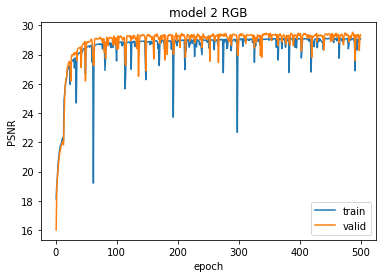

In [53]:
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['val_PSNR'])
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['PSNR'])
plt.title('model 2 RGB')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.savefig("model 2-3 color/PSNR model 2-3 color.png")
plt.show()

In [36]:
layer = model.layers[0]
weights = layer.get_weights()
w = weights[0]
filter1 = Image.new(mode, (w.shape[0],w.shape[1]))
filter2 = Image.new(mode, (w.shape[0],w.shape[1]))
filter3 = Image.new(mode, (w.shape[0],w.shape[1]))
filter4 = Image.new(mode, (w.shape[0],w.shape[1]))
filter5 = Image.new(mode, (w.shape[0],w.shape[1]))
filter6 = Image.new(mode, (w.shape[0],w.shape[1]))
filter7 = Image.new(mode, (w.shape[0],w.shape[1]))
filter8 = Image.new(mode, (w.shape[0],w.shape[1]))
filter9 = Image.new(mode, (w.shape[0],w.shape[1]))
filter10 = Image.new(mode, (w.shape[0],w.shape[1]))
p1 = filter1.load()
p2 = filter2.load()
p3 = filter3.load()
p4 = filter4.load()
p5 = filter5.load()
p6 = filter6.load()
p7 = filter7.load()
p8 = filter8.load()
p9 = filter9.load()
p10 = filter10.load()
w1 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w2 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w3 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w4 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w5 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w6 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w7 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w8 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w9 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
w10 = np.zeros((w.shape[2],w.shape[0],w.shape[1]))
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        helper1 = []
        helper2 = []
        helper3 = []
        helper4 = []
        helper5 = []
        helper6 = []
        helper7 = []
        helper8 = []
        helper9 = []
        helper10 = []
        for k in range(channels):
            helper1.append(int(w[i][j][k][0]*255))
            helper2.append(int(w[i][j][k][1]*255))
            helper3.append(int(w[i][j][k][2]*255))
            helper4.append(int(w[i][j][k][3]*255))
            helper5.append(int(w[i][j][k][4]*255))
            helper6.append(int(w[i][j][k][5]*255))
            helper7.append(int(w[i][j][k][6]*255))
            helper8.append(int(w[i][j][k][7]*255))
            helper9.append(int(w[i][j][k][8]*255))
            helper10.append(int(w[i][j][k][9]*255))
            w1[k,i,j] = int(w[i][j][k][0]*255)
            w2[k,i,j] = int(w[i][j][k][1]*255)
            w3[k,i,j] = int(w[i][j][k][2]*255)
            w4[k,i,j] = int(w[i][j][k][3]*255)
            w5[k,i,j] = int(w[i][j][k][4]*255)
            w6[k,i,j] = int(w[i][j][k][5]*255)
            w7[k,i,j] = int(w[i][j][k][6]*255)
            w8[k,i,j] = int(w[i][j][k][7]*255)
            w9[k,i,j] = int(w[i][j][k][8]*255)
            w10[k,i,j] = int(w[i][j][k][9]*255)
        p1[i,j] = tuple(helper1)
        p2[i,j] = tuple(helper2)
        p3[i,j] = tuple(helper3)
        p4[i,j] = tuple(helper4)
        p5[i,j] = tuple(helper5)
        p6[i,j] = tuple(helper6)
        p7[i,j] = tuple(helper7)
        p8[i,j] = tuple(helper8)
        p9[i,j] = tuple(helper9)
        p10[i,j] = tuple(helper10)
filter1.save('model 2-3 color/filter1.png')
filter2.save('model 2-3 color/filter2.png')
filter3.save('model 2-3 color/filter3.png')
filter4.save('model 2-3 color/filter4.png')
filter5.save('model 2-3 color/filter5.png')
filter6.save('model 2-3 color/filter6.png')
filter7.save('model 2-3 color/filter7.png')
filter8.save('model 2-3 color/filter8.png')
filter9.save('model 2-3 color/filter9.png')
filter10.save('model 2-3 color/filter10.png')

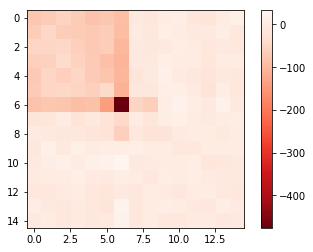

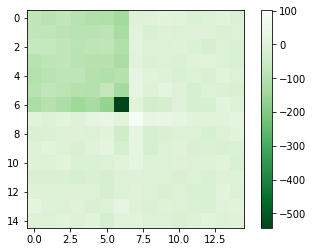

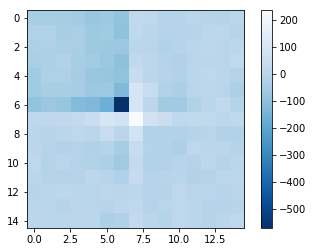

In [54]:
plt.imshow(w1[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt1 reds.png")
plt.show()

plt.imshow(w1[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt1 greens.png")
plt.show()

plt.imshow(w1[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt1 blues.png")
plt.show()

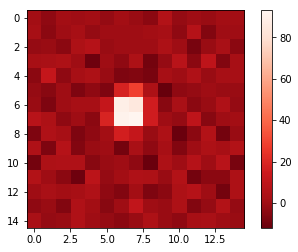

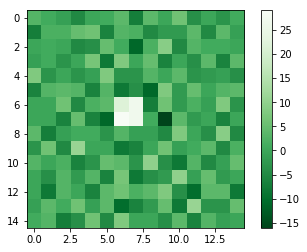

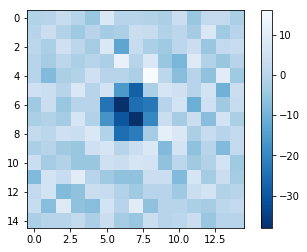

In [55]:
plt.imshow(w2[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt2 reds.png")
plt.show()

plt.imshow(w2[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt2 greens.png")
plt.show()

plt.imshow(w2[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt2 blues.png")
plt.show()

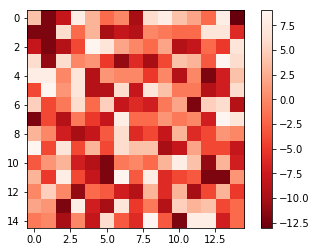

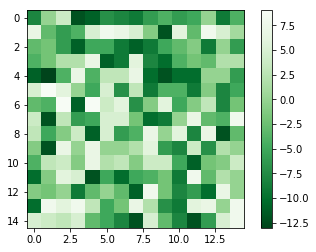

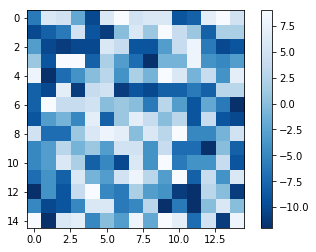

In [56]:
plt.imshow(w3[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt3 reds.png")
plt.show()

plt.imshow(w3[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt3 greens.png")
plt.show()

plt.imshow(w3[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt3 blues.png")
plt.show()

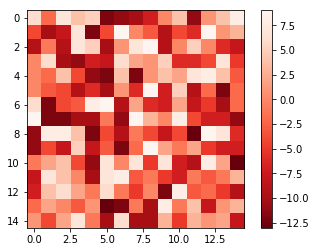

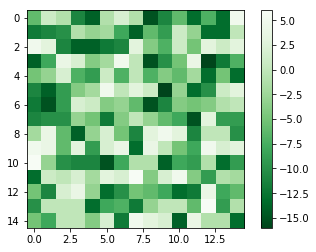

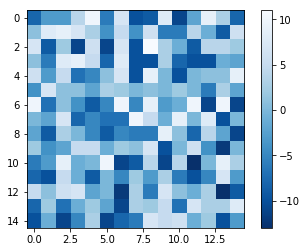

In [57]:
plt.imshow(w4[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt4 reds.png")
plt.show()

plt.imshow(w4[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt4 greens.png")
plt.show()

plt.imshow(w4[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt4 blues.png")
plt.show()

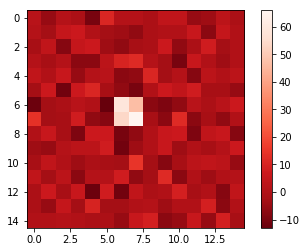

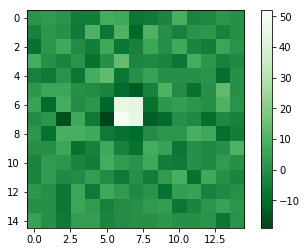

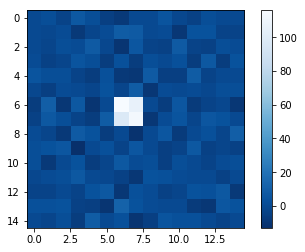

In [62]:
plt.imshow(w5[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt5 reds.png")
plt.show()

plt.imshow(w5[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt5 greens.png")
plt.show()

plt.imshow(w5[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt5 blues.png")
plt.show()

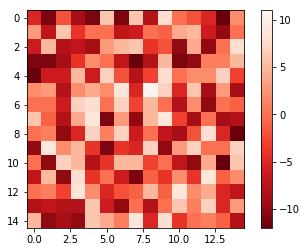

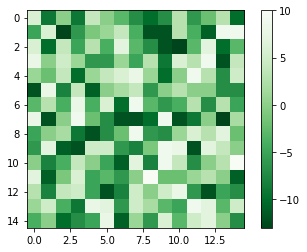

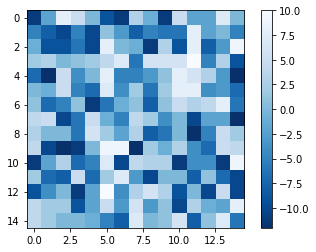

In [63]:
plt.imshow(w6[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt6 reds.png")
plt.show()

plt.imshow(w6[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt6 greens.png")
plt.show()

plt.imshow(w6[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt6 blues.png")
plt.show()

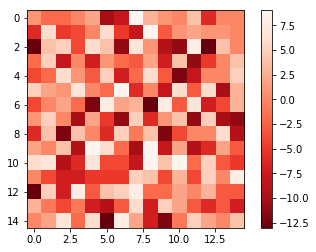

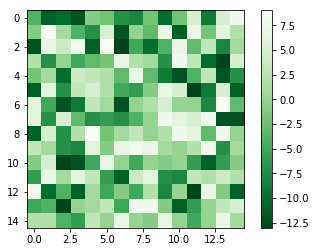

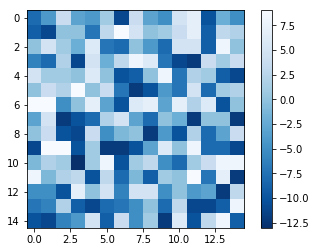

In [64]:
plt.imshow(w7[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt7 reds.png")
plt.show()

plt.imshow(w7[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt7 greens.png")
plt.show()

plt.imshow(w7[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt7 blues.png")
plt.show()

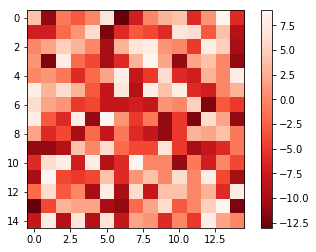

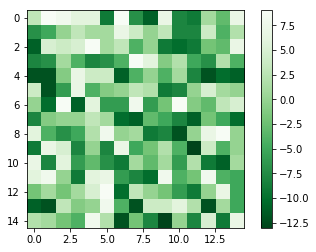

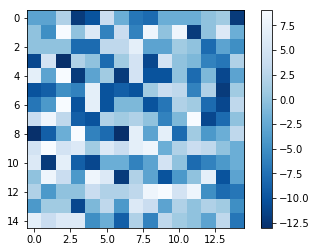

In [65]:
plt.imshow(w8[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt8 reds.png")
plt.show()

plt.imshow(w8[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt8 greens.png")
plt.show()

plt.imshow(w8[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt8 blues.png")
plt.show()

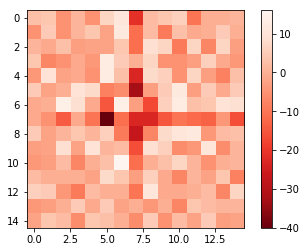

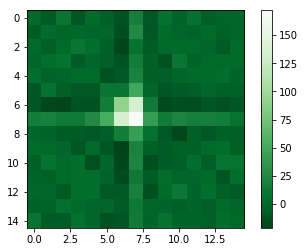

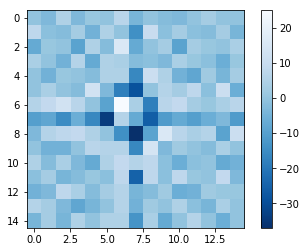

In [66]:
plt.imshow(w9[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt9 reds.png")
plt.show()

plt.imshow(w9[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt9 greens.png")
plt.show()

plt.imshow(w9[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt9 blues.png")
plt.show()

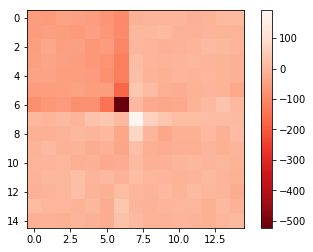

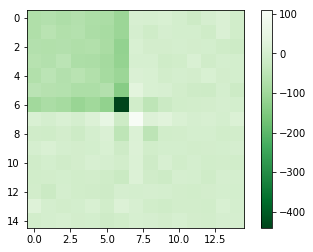

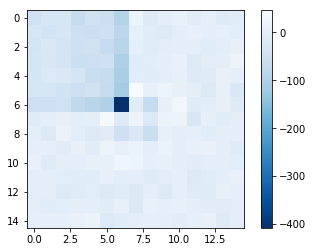

In [67]:
plt.imshow(w10[0].squeeze(), cmap='Reds_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt10 reds.png")
plt.show()

plt.imshow(w10[1].squeeze(), cmap='Greens_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt10 greens.png")
plt.show()

plt.imshow(w10[2].squeeze(), cmap='Blues_r')
plt.colorbar()
plt.savefig("model 2-3 color/filterplt10 blues.png")
plt.show()

In [30]:
model = load_model('model 2-3 color/model 2-3 color.h5', custom_objects={'PSNR': PSNR}) #если нужно выкачать модель

In [31]:
prediction = model.predict(in_test)
prediction5 = model.predict(in_test5)
prediction14 = model.predict(in_test14)

In [32]:
threecompare(in_test[0], out_test[0], prediction[0])

Original image
SSIM: 1.00

Bicubic image
SSIM: 0.94

Bicubic with laplasian image
SSIM: 0.89

Produced image
SSIM: 0.96


In [26]:
print('Результаты для всей тестовой выборки')
results(in_test, out_test, prediction, img_rows, img_cols, 'all')

print('\n'+'Результаты для тестовой выборки Set5')
results(in_test5, out_test5, prediction5, img_rows, img_cols, 'set5')

print('\n'+'Результаты для тестовой выборки Set14')
results(in_test14, out_test14, prediction14, img_rows, img_cols, 'set14')

Результаты для всей тестовой выборки
Bicubic PSNR: 27.2078714506
Laplasian PSNR: 26.6480874616
Model PSNR: 29.6163484276

Результаты для тестовой выборки Set5
Bicubic PSNR: 31.0112492522
Laplasian PSNR: 30.2345389499
Model PSNR: 34.2854515657

Результаты для тестовой выборки Set14
Bicubic PSNR: 26.6066021658
Laplasian PSNR: 26.0811116748
Model PSNR: 28.8782181521


In [27]:
print('Результаты для всей тестовой выборки')
ressim(in_test, out_test, prediction, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set5')
ressim(in_test5, out_test5, prediction5, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set14')
ressim(in_test14, out_test14, prediction14, img_rows, img_cols)

Результаты для всей тестовой выборки
Bicubic SSIM: 0.806364225132
Laplasian SSIM: 0.795693057826
Model SSIM: 0.852194064811

Результаты для тестовой выборки Set5
Bicubic SSIM: 0.892216134629
Laplasian SSIM: 0.880425167524
Model SSIM: 0.930951279471

Результаты для тестовой выборки Set14
Bicubic SSIM: 0.792792048263
Laplasian SSIM: 0.782297908131
Model SSIM: 0.839743475729
